# 8. Correlating on Personality Index (Frame selection)

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

## Description

We correlate gradients with personality index

GOAL: Evaluating correlation level with personality index

## Table of Contents

- [Correlation evaluation on Full films](#correval_full)
- [Correlation evaluation on frame selected](#correval_fselect)



In [3]:
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

psy1 = existing_psy[:len(existing_psy)//2]
psy2 = existing_psy[len(existing_psy)//2:]

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="correval_full"></a>
## Correlation evaluation on Full films

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

In [7]:
all_moviegrads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grad = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grad.keys())
nsub = len(subjects)

In [8]:
super_aligned,_,_ = procrustes_align([all_moviegrads[sub] for sub in subjects])
rest_aligned,_,_ = procrustes_align(list(rest_grad.values()))

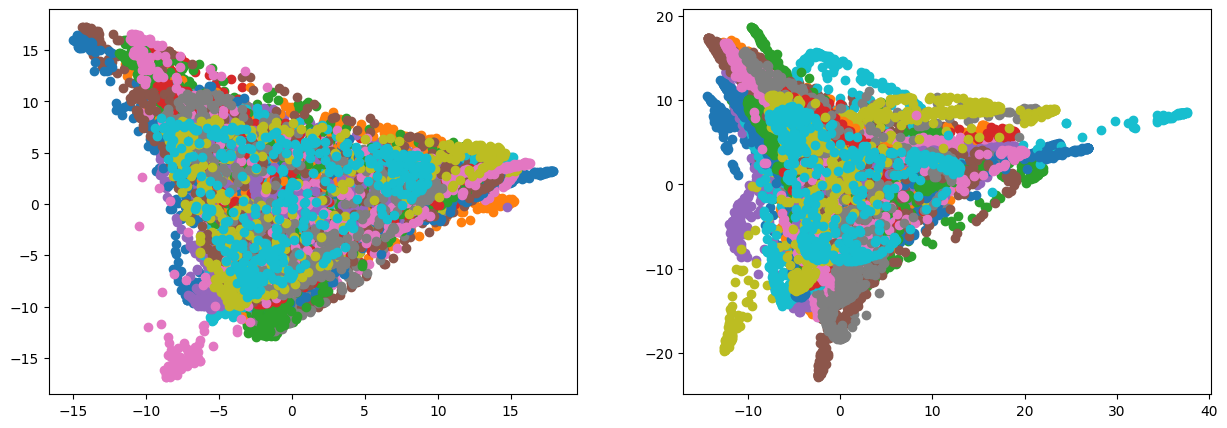

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for k in range(len(rest_aligned)):
    ax[0].scatter(super_aligned[k,:,0], super_aligned[k,:,1])
for k in range(len(rest_aligned)):
    ax[1].scatter(rest_aligned[k,:,0], rest_aligned[k,:,1])

In [10]:
# 1. compute correlation with the position
# 2. compute correlation with the distance to centroid
# 3. compute null distributions 

position_corr = {"pidx": [], "corr":[], "type": [], "gidx": []}
distance_corr = {"pidx": [], "corr":[], "type": []}

for gidx in range(3):
    for k in range(len(existing_psy)):
        feat = existing_psy[k]
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        
        # 1. position_corr
        super_corr = [np.abs(pearson_correlation(super_aligned[:,i,gidx], psyscore))
                      for i in range(super_aligned.shape[1])]
        rest_corr = [np.abs(pearson_correlation(rest_aligned[:,i,gidx], psyscore))
                     for i in range(rest_aligned.shape[1])]
        
        # filling dataframe with info for super aligned
        position_corr["pidx"] += [feat] * len(super_corr)
        position_corr["corr"] += super_corr
        position_corr["type"] += ["movie"] * len(super_corr)
        position_corr["gidx"] += [gidx] * len(super_corr)
        # filling dataframe with info for rest alinged
        position_corr["pidx"] += [feat] * len(rest_corr)
        position_corr["corr"] += rest_corr
        position_corr["type"] += ["rest"] * len(rest_corr)
        position_corr["gidx"] += [gidx] * len(rest_corr)
        
        # 2. distance_corr
        if gidx == 0:
            D_super = np.asarray([D(super_aligned.mean(axis=1)[k],super_aligned[k]) for k in range(nsub)])
            D_rest = np.asarray([D(rest_aligned.mean(axis=1)[k],rest_aligned[k]) for k in range(nsub)])        
            super_corr = [np.abs(pearson_correlation(D_super[:,i], psyscore))
                          for i in range(super_aligned.shape[1])]
            rest_corr = [np.abs(pearson_correlation(D_rest[:,i], psyscore))
                         for i in range(rest_aligned.shape[1])]

            # filling dataframe with info for super aligned
            distance_corr["pidx"] += [feat] * len(super_corr)
            distance_corr["corr"] += super_corr
            distance_corr["type"] += ["movie"] * len(super_corr)
            # filling dataframe with info for rest alinged
            distance_corr["pidx"] += [feat] * len(rest_corr)
            distance_corr["corr"] += rest_corr
            distance_corr["type"] += ["rest"] * len(rest_corr)

pos_corr_df = pd.DataFrame.from_dict(position_corr)
dist_corr_df = pd.DataFrame.from_dict(distance_corr)

Look at null distribution per pidx and see what "chance level" is 

In [11]:
null_iter = 100
super_null1 = {feat: [] for feat in existing_psy}
super_null2 = {feat: [] for feat in existing_psy}
rest_null1 = {feat: [] for feat in existing_psy}
rest_null2 = {feat: [] for feat in existing_psy}

for n in tqdm(range(null_iter)):
    
    for gidx in range(3):
        for k in range(len(existing_psy)):
            feat = existing_psy[k]
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() 
                        for i in range(len(subjects))]
            np.random.shuffle(psyscore)
            
            super_corr = [np.abs(pearson_correlation(super_aligned[:,i,gidx], psyscore))
                          for i in range(super_aligned.shape[1])]
            rest_corr = [np.abs(pearson_correlation(rest_aligned[:,i,gidx], psyscore))
                         for i in range(rest_aligned.shape[1])]

            super_null1[feat].append(super_corr)
            rest_null1[feat].append(rest_corr)

            if gidx == 0:
                D_super = np.asarray([D(super_aligned.mean(axis=1)[k],super_aligned[k]) for k in range(nsub)])
                D_rest = np.asarray([D(rest_aligned.mean(axis=1)[k],rest_aligned[k]) for k in range(nsub)])        
                super_corr = [np.abs(pearson_correlation(D_super[:,i], psyscore))
                              for i in range(super_aligned.shape[1])]
                rest_corr = [np.abs(pearson_correlation(D_rest[:,i], psyscore))
                             for i in range(rest_aligned.shape[1])]

                super_null2[feat].append(super_corr)
                rest_null2[feat].append(rest_corr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
np.percentile(np.asarray(super_null1['bis']).mean(axis=1), 95)

0.2103361721422604

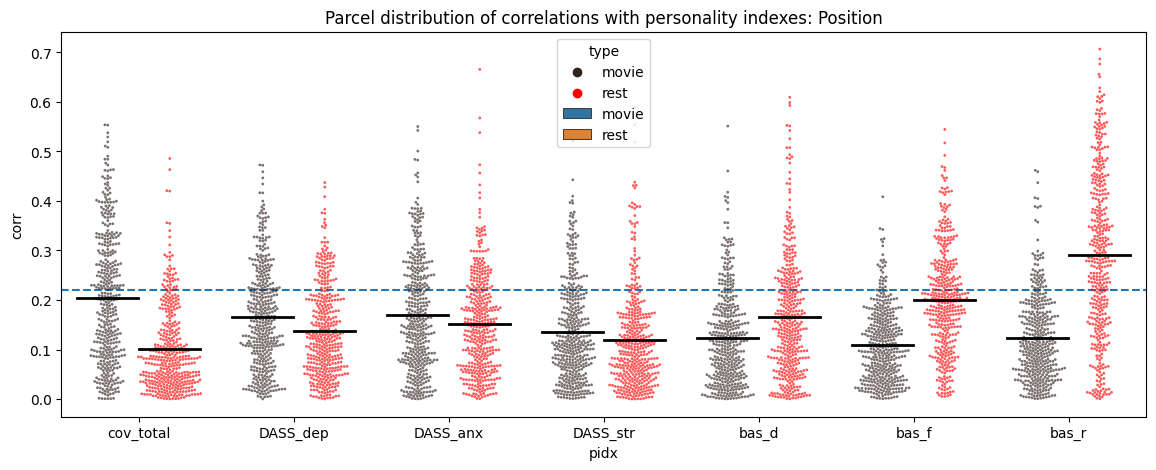

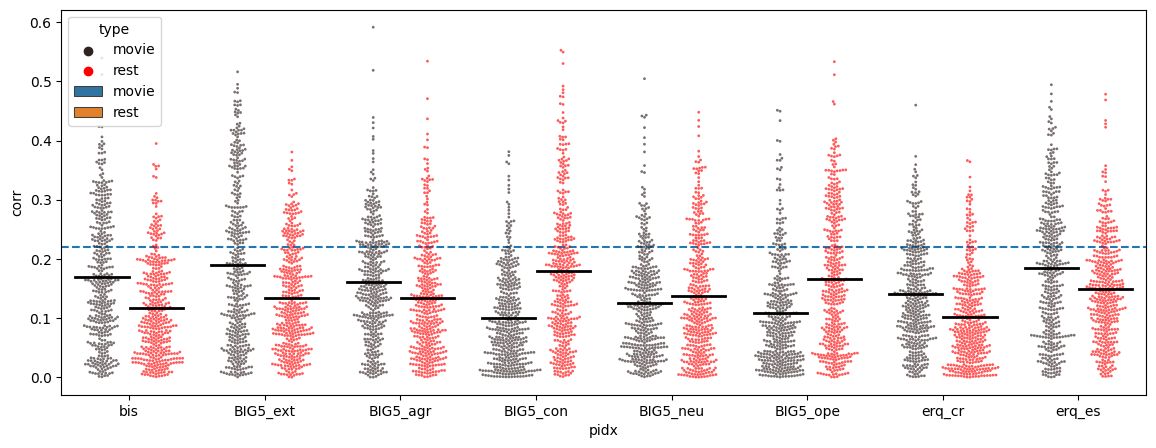

In [22]:
cur_df = pos_corr_df[pos_corr_df['gidx'] == 0]
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.title("Parcel distribution of correlations with personality indexes: Position")
plt.axhline(y=0.22, linestyle='--')
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
# plt.title("Distribution of prediction vs gt correlation on different folds")

plt.axhline(y=0.22, linestyle='--')
plt.show()

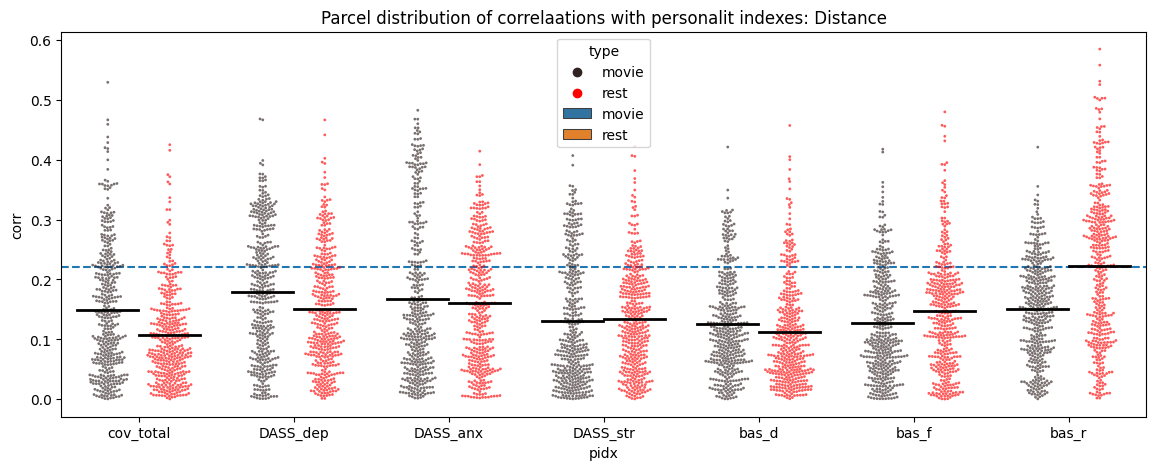

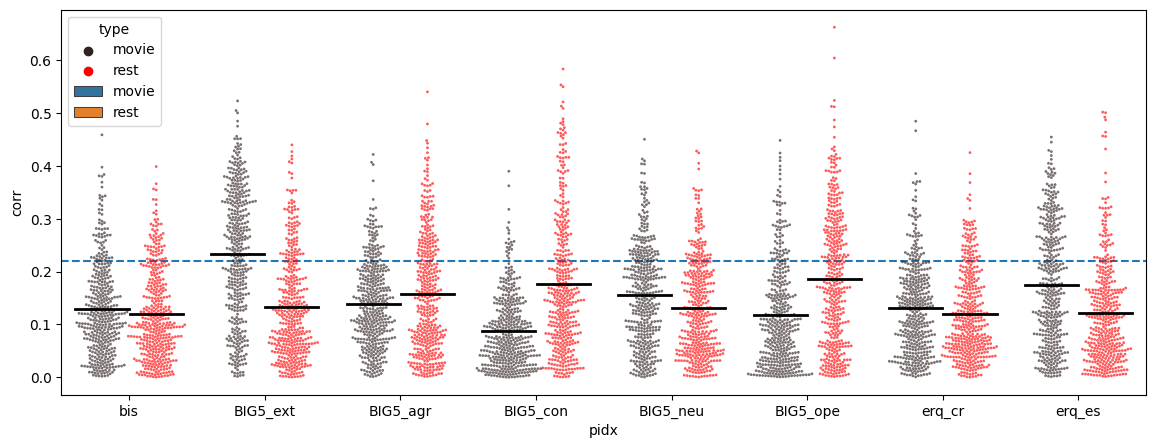

In [23]:
cur_df = dist_corr_df
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)
# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.title("Parcel distribution of correlaations with personality indexes: Distance")
plt.axhline(y=0.22, linestyle='--')
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
              color="r", alpha=.65, size=2, dodge=True)

# plot the mean line
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="pidx",
            y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.axhline(y=0.22, linestyle='--')
# plt.title("Distribution of prediction vs gt correlation on different folds")
plt.show()

<a class="anchor" id="correval_fselect"></a>
## Correlation evaluation on Frame selected

#### Visual difference

In [4]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
nb_comp    = 3
rs         = 99

In [5]:
total_series = load('./data/fmri_414_series.pkl')
f_series = load('./resources/fa_treshed_series.pkl')

if 'Rest' in total_series: del total_series['Rest']
if 'Rest' in f_series: del f_series['Rest']

In [39]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

thresh_all = s5+s10+s20+s25+s33+s50

Script to generate per id 3FA selected gradients (untoggle)

In [7]:
# fa_fselect_gradients = {}
# for k in tqdm(range(3)):
#     all_fselect_gradients = {}
#     for bound in tqdm(s5+s10+s20+s25+s33+s50):
#         fselected_series = f_series[k][bound]
#         fselect_subjects = {_id:[] for _id in fselected_series['Sintel'].keys()}
#         # array swap
#         for mname in fselected_series:
#             tmp_dict = fselected_series[mname]

#             for _id in tmp_dict:
#                 tmp_series = tmp_dict[_id]
#                 fselect_subjects[_id].append(tmp_series)

#         # fselect gradients compute
#         fselect_gradients = {}
#         for _id in fselect_subjects:
#             tmp_series = np.concatenate(fselect_subjects[_id])
#             fc_select = FC(tmp_series)
#             g_select = GradientMaps(n_components=nb_comp, approach=embedding, 
#                                     kernel=aff_kernel, random_state=rs)
#             g_select.fit(fc_select)
#             grad = g_select.gradients_

#             # fscore = D(grad.mean(axis=0), grad)
#             fselect_gradients[_id] = grad

#         all_fselect_gradients[bound] = fselect_gradients

#     fa_fselect_gradients[k] = all_fselect_gradients

# save("./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl", fa_fselect_gradients)

hide()

Script to generate per id random gradients (untoggle)

In [11]:
# np.random.seed(99)

# nb_iter = 200
# for ssize in tqdm([5,10,20,25,33,50]):
#     null_gradients = []

#     for _ in tqdm(range(nb_iter)):
#         frandom_subjects = {_id:[] for _id in total_series['Sintel'].keys()}
#         # array swap
#         for mname in total_series:
#             tmp_dict = total_series[mname]
#             tmp = tmp_dict[next(iter(tmp_dict))]
#             perc_left = tmp.shape[0]*ssize//100
#             sample_idx = np.random.choice(np.arange(tmp.shape[0]),perc_left, replace=False)

#             for _id in tmp_dict:
#                 tmp_series = tmp_dict[_id][sample_idx]
#                 frandom_subjects[_id].append(tmp_series)

#         # all movies gradients compute
#         frandom_gradients = {}
#         for _id in frandom_subjects:
#             tmp_series = np.concatenate(frandom_subjects[_id])
#             fc_random = FC(tmp_series)
#             g_random = GradientMaps(n_components=nb_comp, approach=embedding, 
#                                     kernel=aff_kernel, random_state=rs)
#             g_random.fit(fc_random)
#             grad = g_random.gradients_
#             frandom_gradients[_id] = grad
#         null_gradients.append(frandom_gradients)
#     save("./resources/null_grad/sample_fselect_withID/nullsample_{}.pkl".format(ssize), null_gradients)

hide()

Load the related gradients and compute their properties

In [13]:
fa_fselect_gradients = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [14]:
fa_fselect_dist = {}
for fa_nb in range(3):
    fa_tmp = fa_fselect_gradients[fa_nb]
    per_fa = {}
    for bound in s5+s10+s20+s25+s33+s50:
        per_bound = {}
        tmp_grads = fa_tmp[bound]
        for _id in tmp_grads:
            dist = D(tmp_grads[_id].mean(axis=0),tmp_grads[_id])
            per_bound[_id] = dist

        per_fa[bound] = per_bound
    fa_fselect_dist[fa_nb] = per_fa

In [30]:
null_dist = {}
for ssize in [5,10,20,25,33,50]:
    tmp = load("./resources/null_grad/sample_fselect_withID/nullsample_{}.pkl".format(ssize))
    dists = []
    for n_iter in range(len(tmp)):
        per_iter = {}
        tmp_grads = tmp[n_iter]
        for _id in tmp_grads:
            dist = D(tmp_grads[_id].mean(axis=0),tmp_grads[_id])
            per_iter[_id] = dist
        dists.append(per_iter)
    null_dist[ssize] = dists

### Correlation Computation Full Gradients

In [60]:
# we use Valence for now
all_fselect_gradients = deepcopy(fa_fselect_dist[2])

#### Null distrib versus bounds

In [61]:
subjects = list(all_fselect_gradients[(0,5)].keys())

In [62]:
bound_pred_distrib = {}
for bound in tqdm(thresh_all):
    # choice for fselect
    fselect_gradients = all_fselect_gradients[bound]
    fselect_array = np.asarray([fselect_gradients[sub] for sub in subjects])
    
    pred_distrib = {}

    for k in range(len(existing_psy)):
        feat = existing_psy[k]
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

        fselect_corr = [pearson_correlation(fselect_array[:,i], psyscore) for i in range(fselect_array.shape[1])]
        pred_distrib[feat] = np.abs(fselect_corr)
    
    bound_pred_distrib[bound] = pred_distrib

  0%|          | 0/44 [00:00<?, ?it/s]

In [46]:
bound_null_distrib = {}
for ssize in tqdm([5,10,20,25,33,50]):
    null_distrib = {feat: [] for feat in existing_psy}
    ssize_dist = null_dist[ssize]
    for nb in tqdm(range(nb_iter)):
        frandom_gradients = ssize_dist[nb]
        fmovie_array = np.asarray([frandom_gradients[sub] for sub in subjects])
        
        for k in range(len(existing_psy)):
            feat = existing_psy[k]
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
            fmovie_corr = [pearson_correlation(fmovie_array[:,i], psyscore) for i in range(fmovie_array.shape[1])]

            null_distrib[feat].append(np.abs(fmovie_corr))
    bound_null_distrib[ssize] = null_distrib

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [63]:
bound_null_scores = {bound: {} for bound in thresh_all}
for bound in thresh_all:
    l,r = bound
    ssize = r-l
    if ssize == 34: ssize = 33

    pred_distrib = bound_pred_distrib[bound]
    null_distrib = bound_null_distrib[ssize]
    for feat in existing_psy:
        ndistrib = [np.mean(dis) for dis in null_distrib[feat]]
        sample = np.mean(pred_distrib[feat])
    
        bound_null_scores[bound][feat] = null_score(ndistrib, sample)

In [66]:
pd.DataFrame.from_records(bound_null_scores)[s20]

,"(0, 20)","(20, 40)","(40, 60)","(60, 80)","(80, 100)"
cov_total,0.275,0.615,0.795,0.945,0.510
DASS_dep,0.380,0.010,0.050,0.480,0.940
DASS_anx,0.005,0.005,0.155,0.865,0.580
DASS_str,0.170,0.000,0.230,0.245,0.925
bas_d,0.450,0.200,0.160,0.845,0.570
bas_f,0.085,0.180,0.360,0.985,0.430
bas_r,0.310,0.715,0.375,0.935,0.000
bis,0.020,0.220,0.445,1.000,0.335
BIG5_ext,0.435,0.785,0.000,0.850,0.260
BIG5_agr,0.515,0.280,0.100,0.170,0.585


We therefore want to focus on these pidx: 

#### Across different bounds of frame selection

In [97]:
B = s25
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in B])

In [98]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in range(414)] 
                for k in range(len(all_array))]
    
    for k in range(len(all_corr)):
        pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[k]))
        pred_distrib_selects['pidx'] += len(all_corr[k]) * [feat]
        pred_distrib_selects['type'] += len(all_corr[k]) * [B[k]]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

<Figure size 2500x500 with 0 Axes>

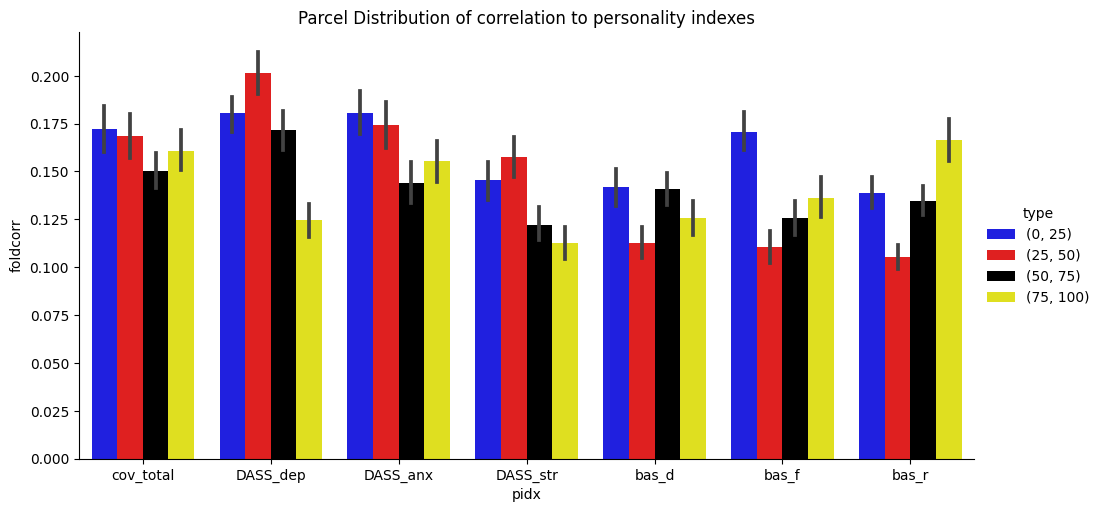

<Figure size 2500x500 with 0 Axes>

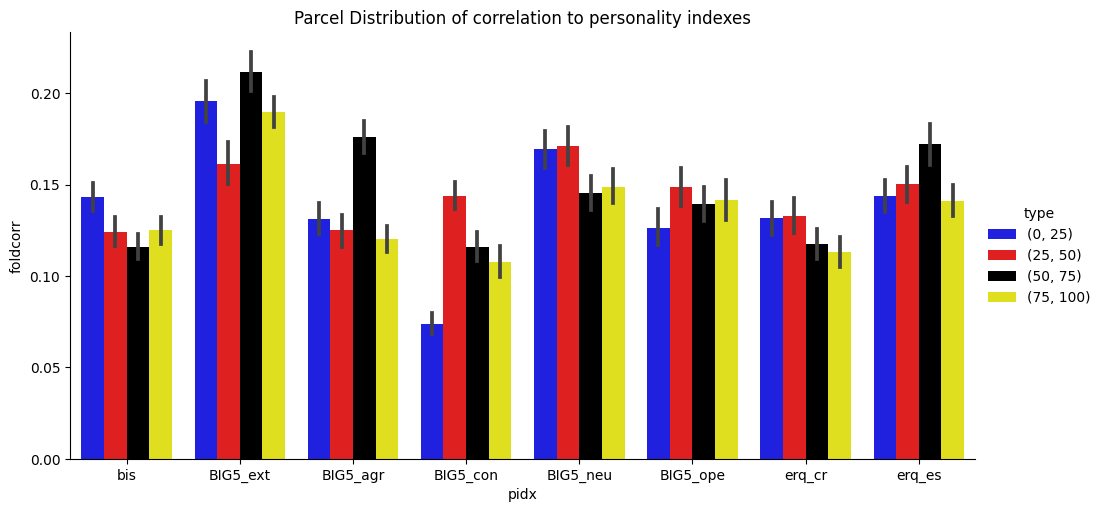

In [99]:
plt.figure(figsize=(25,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

plt.figure(figsize=(25,5))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])], 
            kind='bar', height=5, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

### Network level (we show yeo 17)

In [111]:
B = s33
all_array = np.asarray([[all_fselect_gradients[s][sub] for sub in subjects] for s in B])

In [112]:
pred_distrib_selects = {'pidx': [], 'foldcorr': [], 'type': [], 'net': []}

for k in range(len(existing_psy)):
    feat = existing_psy[k]
    psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
    
    for net in index2region17:
        
        all_corr = [[pearson_correlation(all_array[k,:,i], psyscore) for i in index2region17[net]] 
                    for k in range(len(all_array))]

        for k in range(len(all_corr)):
            pred_distrib_selects['foldcorr'] += list(np.abs(all_corr[k]))
            pred_distrib_selects['pidx'] += len(all_corr[k]) * [feat]
            pred_distrib_selects['type'] += len(all_corr[k]) * [B[k]]
            pred_distrib_selects['net'] += len(all_corr[k]) * [net]

pred_selects_df = pd.DataFrame.from_dict(pred_distrib_selects)

<Figure size 3500x3500 with 0 Axes>

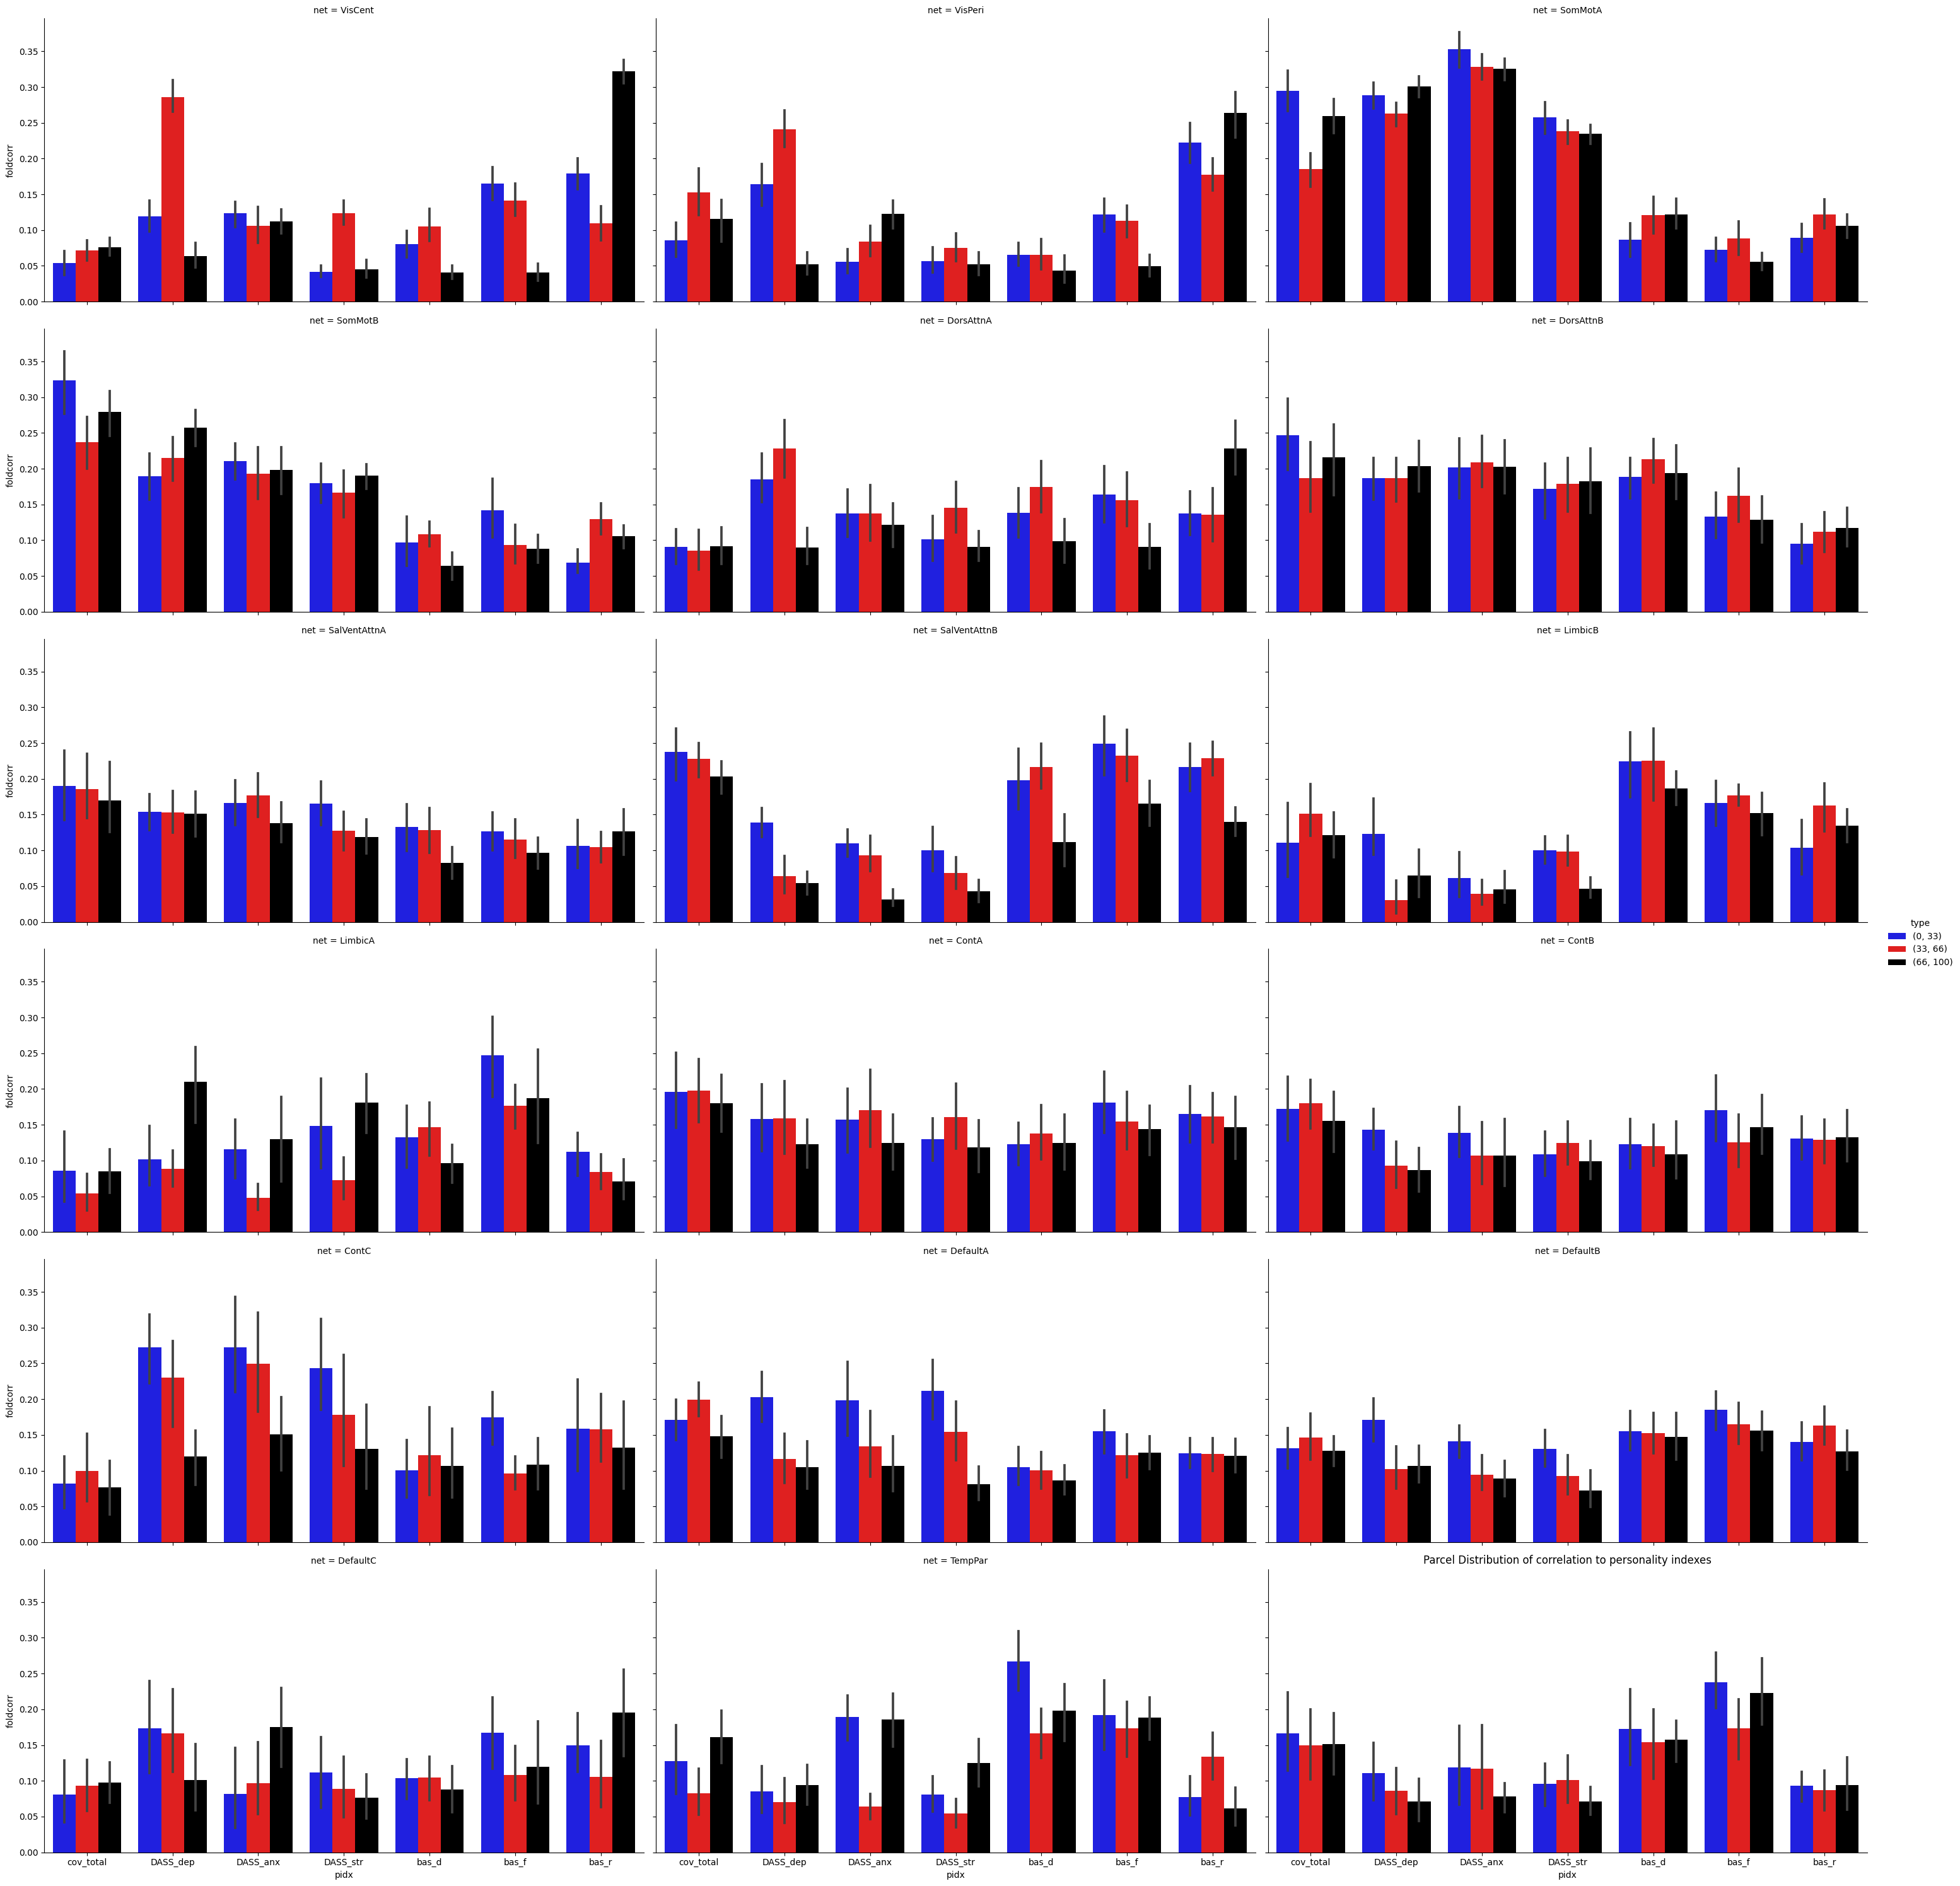

In [113]:
plt.figure(figsize=(35,35))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[:len(existing_psy)//2])], 
            kind='bar', height=5, col='net', col_wrap=3, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()

<Figure size 3500x3500 with 0 Axes>

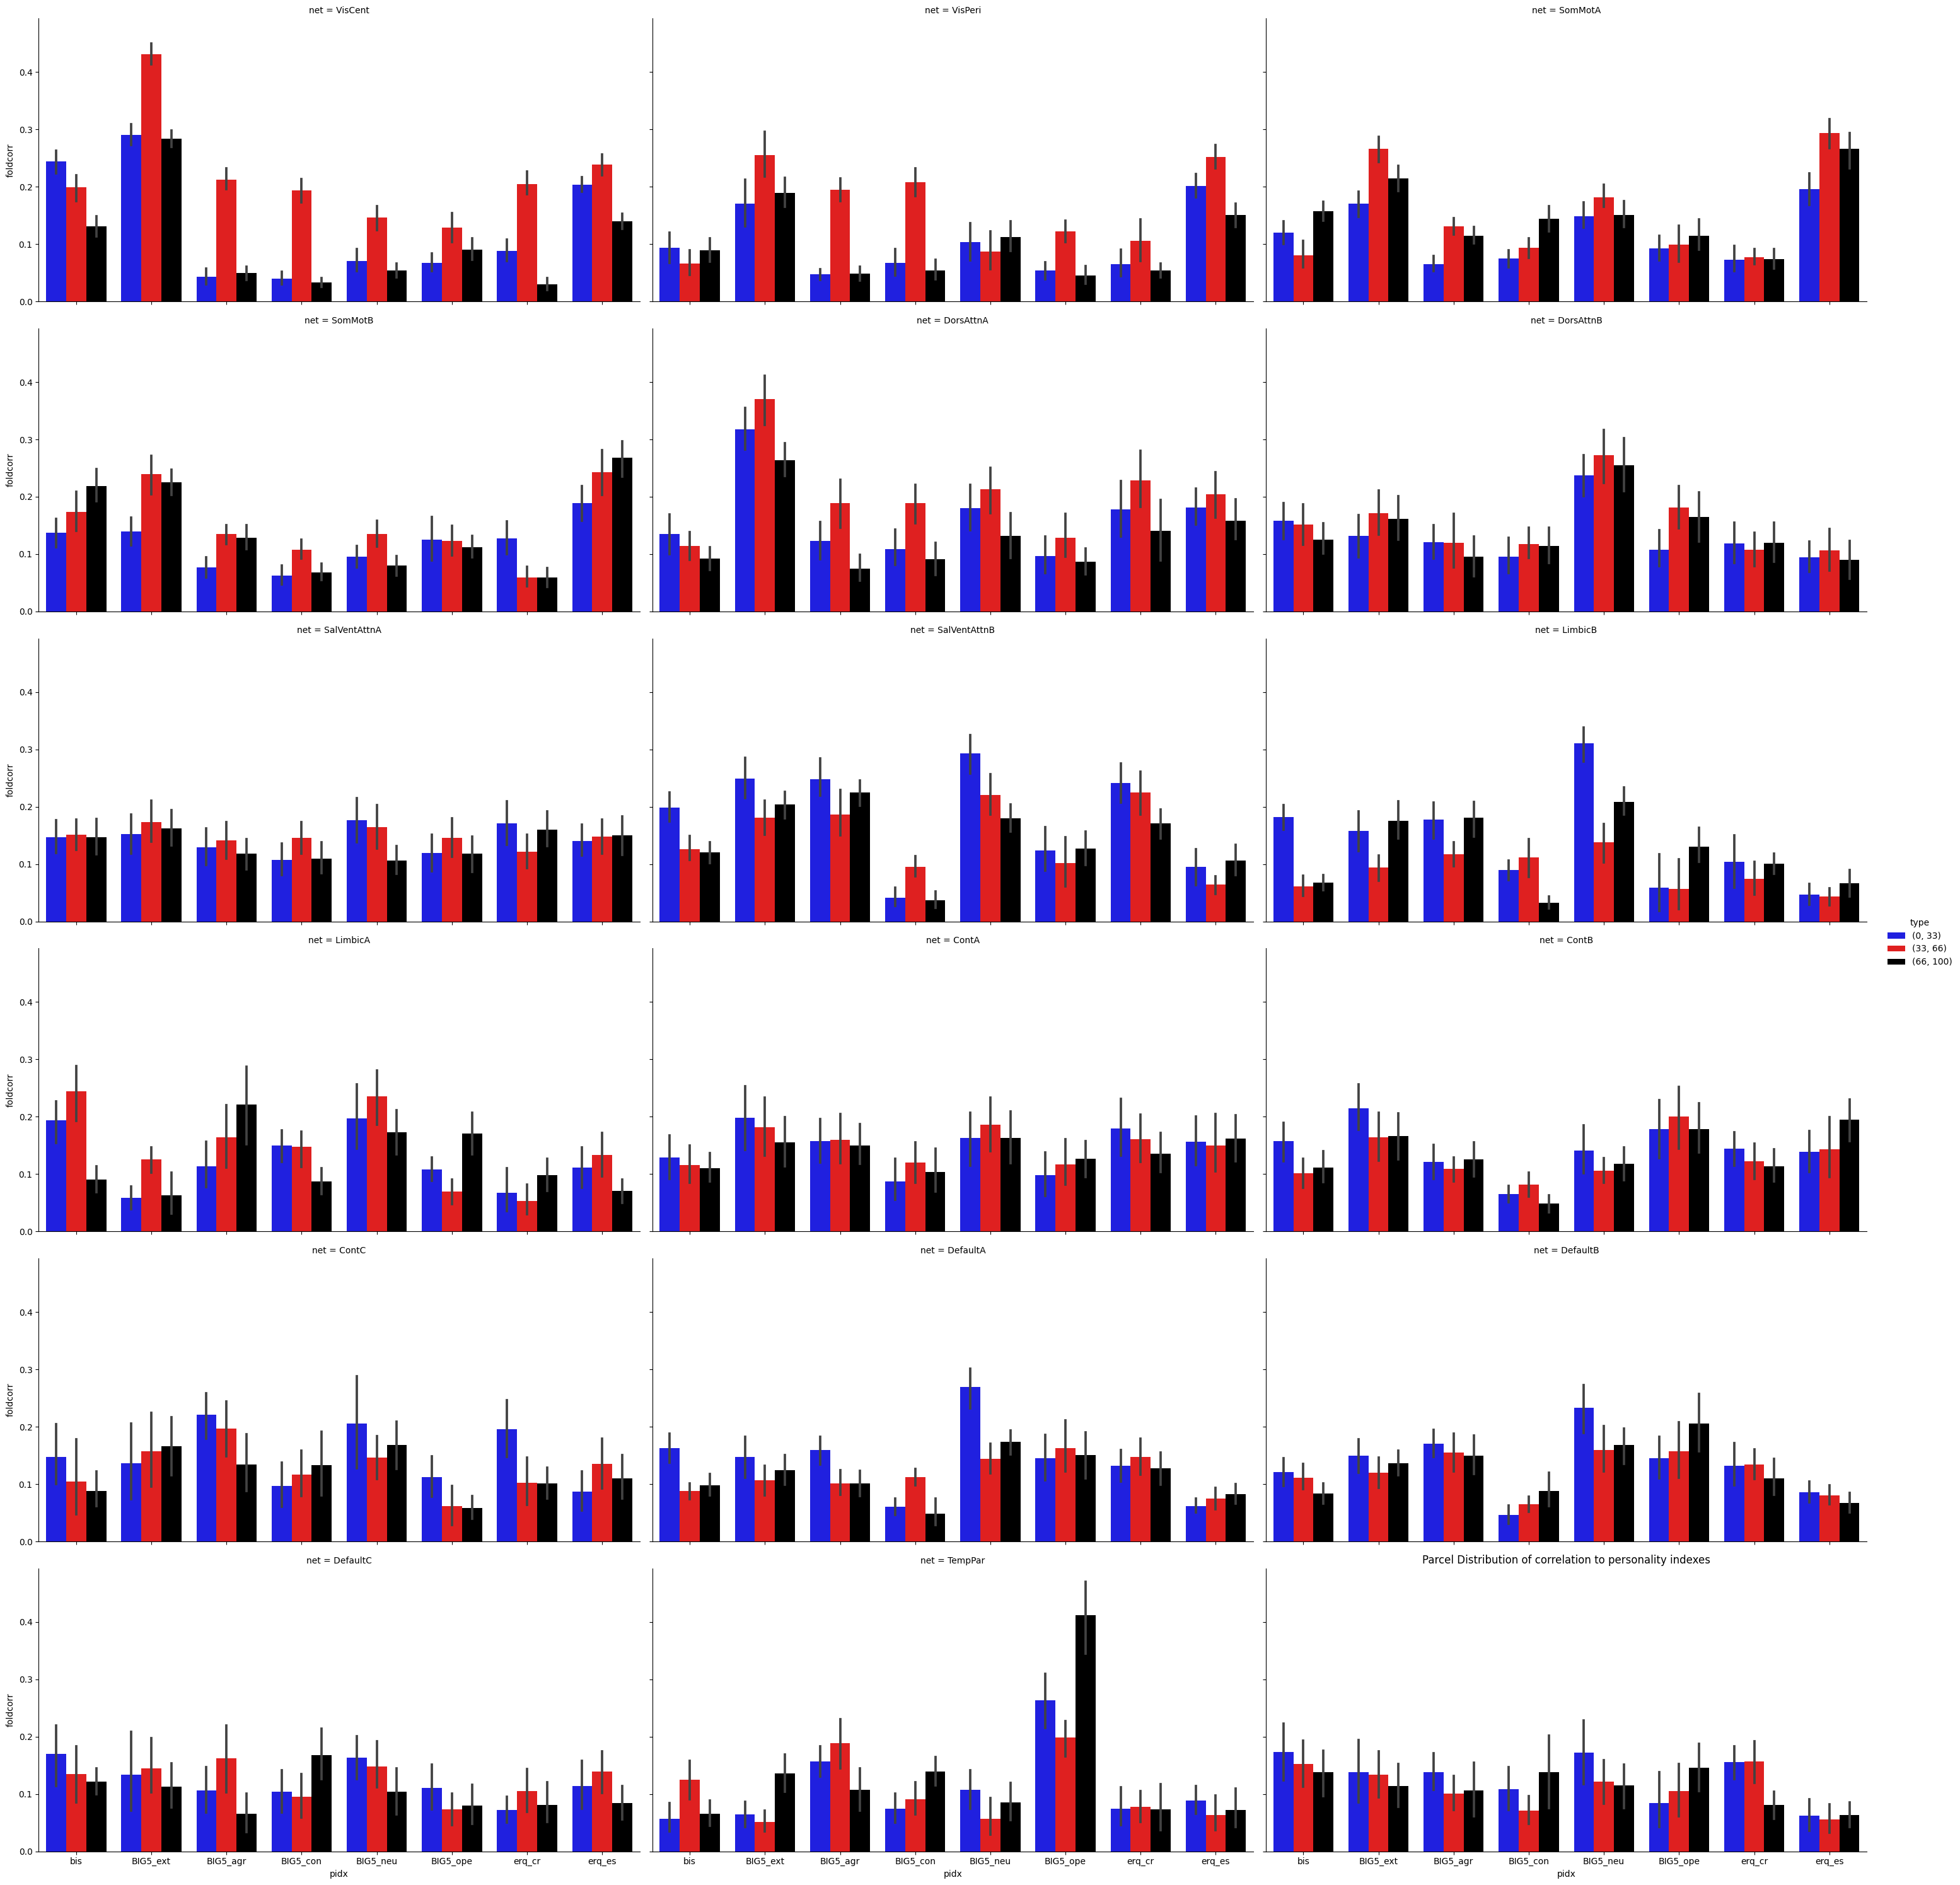

In [114]:
plt.figure(figsize=(35,35))
sns.catplot(x='pidx', y='foldcorr', hue='type', data=pred_selects_df[pred_selects_df['pidx'].isin(existing_psy[len(existing_psy)//2:])], 
            kind='bar', height=5, col='net', col_wrap=3, aspect=2, palette=sns.color_palette(['blue', 'red', 'black', 
                                                                       'yellow', 'orange', 'green',
                                                                      'purple', 'cyan']))
plt.title("Parcel Distribution of correlation to personality indexes")

plt.show()